## Evaluating K-means clustering

In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine

from sklearn import datasets, metrics

In [3]:
# Load the dataset from the Thinkful's database. Here's the credentials you can use to connect to the database:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

heartdisease_df = pd.read_sql_query('select * from heartdisease',con=engine)

engine.dispose()

In [75]:
heartdisease_df.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1


In [5]:
heartdisease_df.shape

(303, 14)

### Prep Data

In [44]:
# The dataset needs some preprocessing. So, apply the following code before working with the dataset:

# Define the features and the outcome
X = heartdisease_df.iloc[:, :13]
y = heartdisease_df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
y = np.where(y > 0, 0, 1)

### 1. Split the data randomly into two and apply k-means using two, three and four as the number of clusters as we did in our discussion of the consistency in this checkpoint. Assess the consistency of the solutions using visualization. Which one does seem to be the best one?

In [45]:
X.shape

(303, 13)

In [46]:
y.shape

(303,)

In [68]:
y = y[0:302]

In [58]:
X.index

RangeIndex(start=0, stop=303, step=1)

In [62]:
X = X.drop(X.index[302])

In [63]:
X.shape

(302, 13)

In [69]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5)

In [73]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
#     Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred


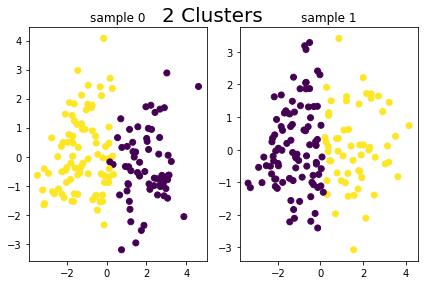

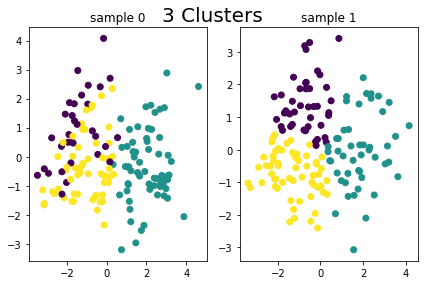

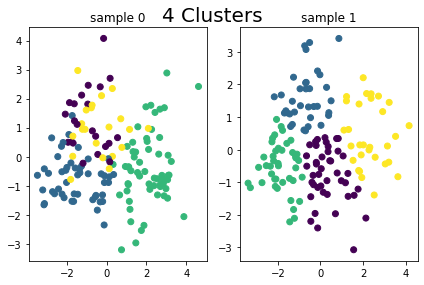

In [74]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

## 2. Apply k-means on the whole dataset by setting k is equal two, three and four and get **ARI score** for each of them. Which model is the best?
The **Adjusted Rand Index (ARI)** applies $\mathbb{E}(RI)$ as a correction factor. With ARI, it is possible to get values less than 0, but 1 still indicates perfect agreement, and 0 indicates perfect randomness.

### 2 clusters

In [11]:
# Get predicted clusters.
full_pred = KMeans(n_clusters=2).fit_predict(X_std)

full_pred = np.array([0 if x == 1 else 1 if x==0 else 2 for x in full_pred])

pd.crosstab(y, full_pred)
metrics.adjusted_rand_score(y, full_pred)

0.4380857727169879

### 3 clusters

In [8]:
# Get predicted clusters.
full_pred = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)

full_pred = np.array([0 if x == 1 else 1 if x==0 else 2 for x in full_pred])

pd.crosstab(y, full_pred)
metrics.adjusted_rand_score(y, full_pred)

0.2740064669723646

### 4 clusters

In [9]:
# Get predicted clusters.
full_pred = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

full_pred = np.array([0 if x == 1 else 1 if x==0 else 2 for x in full_pred])

pd.crosstab(y, full_pred)
metrics.adjusted_rand_score(y, full_pred)

0.19754403059138773

As the clusters increase, the Adjusted Random Index decreases - approaching a higher level of randomness.

## 3. Apply k-means on the whole dataset by setting k equal two, three and four and get **silhouette coefficient** for each of them. Which model is the best?

For each datapoint, the *silhouette coefficient* is the difference between the mean distance between that datapoint and all other points in its cluster ($a_i$) and the mean distance between that datapoint and all other points in the *nearest other* cluster ($b_i$), divided by whichever of the two values is highest:  

$$\dfrac{b_i-a_i}{max(b_i,a_i)}$$

The mean of the silhouette coefficients for all datapoints is the silhouette coefficient for that clustering solution on that data. Values range from -1 for very bad clusters to +1 for very dense clusters. However, if clusters employ non-flat geometry, this index will not work well.

### 2 clusters

In [13]:
labels = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)

print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.17530682286260937


### 3 clusters

In [14]:
labels = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)

print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.1299061055112915


### 4 clusters

In [15]:
labels = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.13347392846804823


2 clusters provides the highest silhoutte coefficient, as a result this is the optimal number of clusters.